# Speech Synthesis 语音合成
## text processing
将文本进行处理 作为模型的输入 注意这里要encode为characters和phonemes
## spectrogram generation
通过文本输入，输出频谱图，使用Tacotron2进行处理
## time-domain conversion
将频谱图转化为waveform 使用WaveRNN Griffin-Lim 和 Nvidia's WaveGlow

In [36]:
import IPython
import matplotlib
import matplotlib.pyplot as plt

import torch
import torchaudio

import os

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(0)
device = "cuda:1" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchaudio.__version__)
print(device)

1.11.0
0.11.0
cuda:1


In [ ]:
# text processing
# 将character转化为int表示

In [4]:
# 一个自定义的将character转化为token表示的方法
symbols = "_-!'(),.:;? abcdefghijklmnopqrstuvwxyz" # 注意这里要带标点符号，因为音频的输出结果其实和标点符号有关系
look_up_table = {s:i for i, s in enumerate(symbols)}
symbols = set(symbols)
look_up_table

{'_': 0,
 '-': 1,
 '!': 2,
 "'": 3,
 '(': 4,
 ')': 5,
 ',': 6,
 '.': 7,
 ':': 8,
 ';': 9,
 '?': 10,
 ' ': 11,
 'a': 12,
 'b': 13,
 'c': 14,
 'd': 15,
 'e': 16,
 'f': 17,
 'g': 18,
 'h': 19,
 'i': 20,
 'j': 21,
 'k': 22,
 'l': 23,
 'm': 24,
 'n': 25,
 'o': 26,
 'p': 27,
 'q': 28,
 'r': 29,
 's': 30,
 't': 31,
 'u': 32,
 'v': 33,
 'w': 34,
 'x': 35,
 'y': 36,
 'z': 37}

In [5]:
def text_to_sequence(text : str):
    text = text.strip().lower()
    return [look_up_table[t] for t in text if t in symbols]

In [6]:
test_text= "I just want to know how to get audio embedding!"
text_to_sequence(test_text)

[20,
 11,
 21,
 32,
 30,
 31,
 11,
 34,
 12,
 25,
 31,
 11,
 31,
 26,
 11,
 22,
 25,
 26,
 34,
 11,
 19,
 26,
 34,
 11,
 31,
 26,
 11,
 18,
 16,
 31,
 11,
 12,
 32,
 15,
 20,
 26,
 11,
 16,
 24,
 13,
 16,
 15,
 15,
 20,
 25,
 18,
 2]

In [7]:
# 使用torchaudio提供的方法将输入的character转换为pre-trained tacotron需要的表示形式
processor = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_CHAR_LJSPEECH.get_text_processor() # tacotron对应的对文本的处理器
processed, length = processor(test_text)
print(processed)
print(length)

tensor([[20, 11, 21, 32, 30, 31, 11, 34, 12, 25, 31, 11, 31, 26, 11, 22, 25, 26,
         34, 11, 19, 26, 34, 11, 31, 26, 11, 18, 16, 31, 11, 12, 32, 15, 20, 26,
         11, 16, 24, 13, 16, 15, 15, 20, 25, 18,  2]])
tensor([47], dtype=torch.int32)


In [ ]:
# tacotron的输入中不仅要有character 在实作的时候还需要phoneme 能增强模型的鲁棒性 减少因为语料character过少而导致发音错误的情况
# phoneme-based encoding

In [11]:
# 使用torchaudio自带的对应于tacotron的phone转为int的结果
processor_phone = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH.get_text_processor()
# 这一步我是手动下载并放在.cache/torch/xxx下的

In [12]:
# 使用processor_phone将输入转化为phone对应的int表示
with torch.inference_mode():
    processed_phone, length_phone = processor_phone(test_text)
print(processed_phone)
print(length_phone)

tensor([[32, 11, 63, 20, 79, 81, 11, 92, 12, 67, 81, 11, 81, 20, 11, 67, 69, 11,
         54, 28, 11, 81, 20, 11, 53, 40, 81, 11, 12, 38, 59, 69, 11, 40, 66, 36,
         40, 38, 55, 68,  2]])
tensor([41], dtype=torch.int32)


In [13]:
# text -> audio-spectrogram 使用tacotron2进行处理
# 下载tacotron2
tacotron2 = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH.get_tacotron2().to(device)

Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_phonemes_1500_epochs_wavernn_ljspeech.pth" to /home/wy/.cache/torch/hub/checkpoints/tacotron2_english_phonemes_1500_epochs_wavernn_ljspeech.pth


  0%|          | 0.00/107M [00:00<?, ?B/s]

In [15]:
with torch.inference_mode():
    processed_phone_, length_phone_ = processor_phone(test_text)
    processed_phone_ = processed_phone_.to(device)
    length_phone_ = length_phone_.to(device)
    spec_test, _, _ = tacotron2.infer(processed_phone_, length_phone_)

In [16]:
spec_test.shape
# [batch, frequency, time frames]
# frequency是确定的80维的embedding 这是tacotron定义的

torch.Size([1, 80, 222])

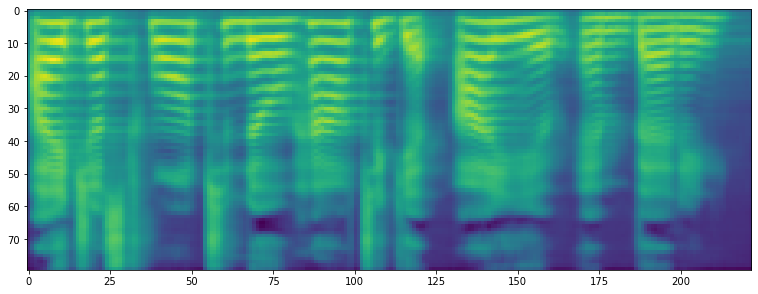

In [17]:
plt.imshow(spec_test[0].cpu().detach())

torch.Size([80, 252])
torch.Size([80, 237])
torch.Size([80, 242])


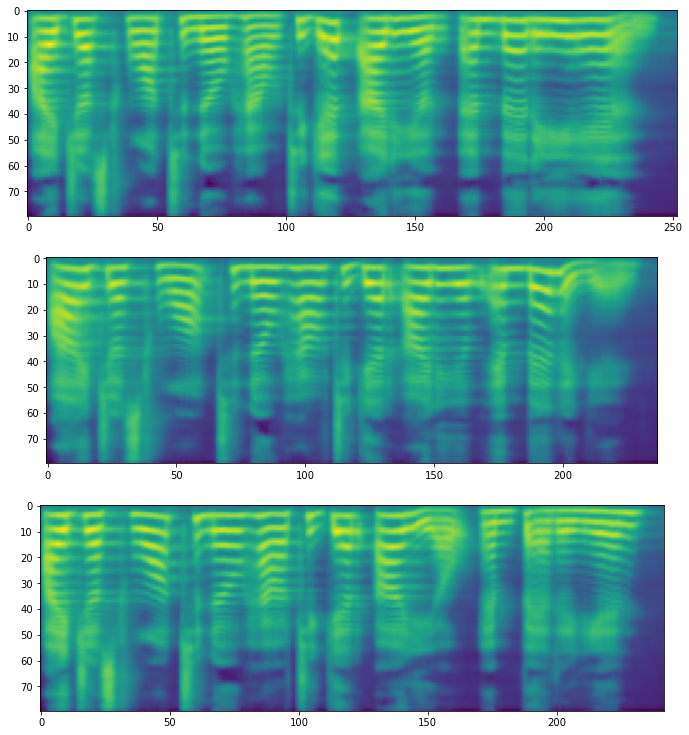

In [18]:
# 注意一点，重复对同一个输入运行infer 得到的结果不尽相同
fig, ax = plt.subplots(3, 1, figsize=(16, 4.3 * 3))
for i in range(3):
    with torch.inference_mode():
        spec, spec_lengths, _ = tacotron2.infer(processed_phone_, length_phone_)
    print(spec[0].shape) # 最终的时域长度都会不同
    ax[i].imshow(spec[0].cpu().detach())
plt.show()

In [ ]:
# 最后要将spectrogram转化为waveform
# 三种方法 WaveRNN GriffinLim

In [23]:
# WaveRNN 因为tacotron就提供WaveRNN作为Vocoder
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH # 这是一个tacotron2作为encoder-decoder WaveRNN作为vocoder 使用phone处理输入音频合成的pipeline

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

In [24]:
test_texts = ['I dont know how to do my graduation project!', 'I dont know how to get audio embedding.', 'who can help me?']

In [25]:
with torch.inference_mode():
    phones, lengths = processor(test_texts)
    phones = phones.to(device)
    lengths = lengths.to(device)
    specs, spec_lengths, _ = tacotron2.infer(phones, lengths)
    waveforms, lengths = vocoder(specs, spec_lengths)

In [26]:
print('specs shape: ', specs.shape)
print('waveforms shape: ', waveforms.shape)

specs shape:  torch.Size([3, 80, 243])
waveforms shape:  torch.Size([3, 66825])


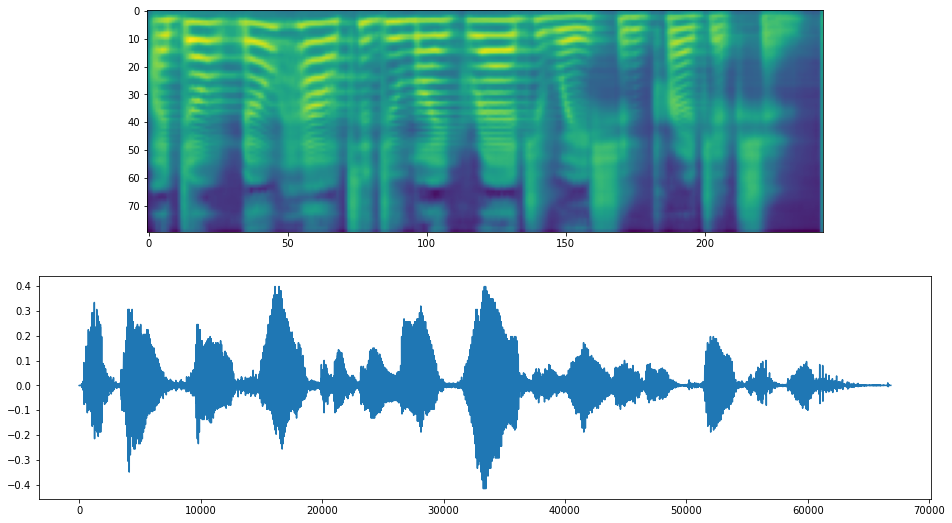

In [48]:
fig, [ax1, ax2] = plt.subplots(2,1,figsize = (16,9))
ax1.imshow(specs[0].cpu().detach())
ax2.plot(waveforms[0].cpu().detach())
# 得到的频谱图和波形图

In [35]:
data_root_path = 'audio_study/data/generated_data/'

In [40]:
waveforms[0:1,:].shape

torch.Size([1, 66825])

In [41]:
torchaudio.save(
    os.path.join(data_root_path,'audio1.wav'),
    waveforms[0:1,:].cpu(),
    sample_rate = vocoder.sample_rate
)

In [44]:
IPython.display.Audio(os.path.join(data_root_path,'audio1.wav'))

In [42]:
torchaudio.save(
    os.path.join(data_root_path,'audio2.wav'),
    waveforms[1:2,:].cpu(),
    sample_rate = vocoder.sample_rate
)

In [45]:
IPython.display.Audio(os.path.join(data_root_path,'audio2.wav'))

In [43]:
torchaudio.save(
    os.path.join(data_root_path,'audio3.wav'),
    waveforms[2:3,:].cpu(),
    sample_rate = vocoder.sample_rate
)

In [46]:
IPython.display.Audio(os.path.join(data_root_path,'audio3.wav'))

In [49]:
# Griffin-Lim tacotron也提供Griffin-Lim作为Vocoder
bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH # 这是一个tacotron2作为encoder-decoder Griffin-lim作为vocoder 使用phone处理输入音频合成的pipeline

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_phonemes_1500_epochs_ljspeech.pth" to /home/wy/.cache/torch/hub/checkpoints/tacotron2_english_phonemes_1500_epochs_ljspeech.pth


  0%|          | 0.00/107M [00:00<?, ?B/s]

In [51]:
with torch.inference_mode():
    phones, lengths = processor(test_texts)
    phones = phones.to(device)
    lengths = lengths.to(device)
    specs, spec_lengths, _ = tacotron2.infer(phones, lengths)

# griffin-lim是一个确定性算法 无需inference_mode
waveforms, lengths = vocoder(specs, spec_lengths)

In [52]:
print('specs shape: ', specs.shape)
print('waveforms shape: ', waveforms.shape)

specs shape:  torch.Size([3, 80, 282])
waveforms shape:  torch.Size([3, 71936])


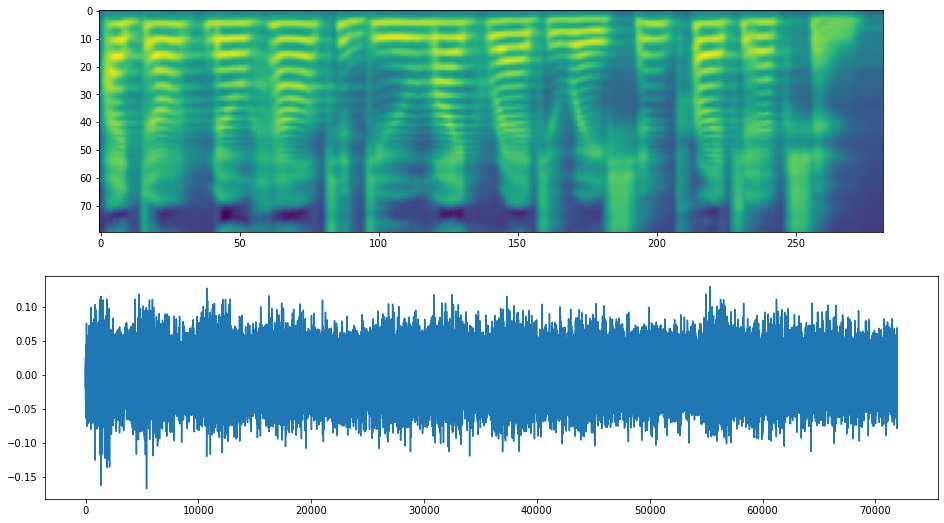

In [56]:
fig, [ax1, ax2] = plt.subplots(2,1,figsize = (16,9))
ax1.imshow(specs[0].cpu().detach())
ax2.plot(waveforms[0].cpu().detach())
# 得到的频谱图和波形图
# 很显然效果很差

In [57]:
torchaudio.save(
    os.path.join(data_root_path,'audio_griffin-lim.wav'),
    waveforms[0:1,:].cpu(),
    sample_rate = vocoder.sample_rate
)

In [58]:
IPython.display.Audio(os.path.join(data_root_path,'audio_griffin-lim.wav'))

In [ ]:
# waveglow 是一个Nvidia提供的vocoder 可以从torch.hub下载

In [59]:
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)
checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",  # noqa: E501
    progress=False,
    map_location=device,
)

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to /home/wy/.cache/torch/hub/torchhub.zip
/home/wy/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/wy/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/wy/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/waveglow/model.py:55: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, '

In [60]:
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}
# 载入参数
waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(256,))
  (WN): ModuleList(
    (0): WN(
      (in_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (res_skip_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
        (1): Conv1d(51

In [62]:
print('----------------------------------------------num of parameters----------------------------------------------')
print(sum(p.numel() for p in waveglow.parameters()))
# 这参数量也太大了吧

----------------------------------------------num of parameters----------------------------------------------
267999848


In [64]:
with torch.no_grad():
    waveforms = waveglow.infer(spec)

In [67]:
spec.shape

torch.Size([1, 80, 242])

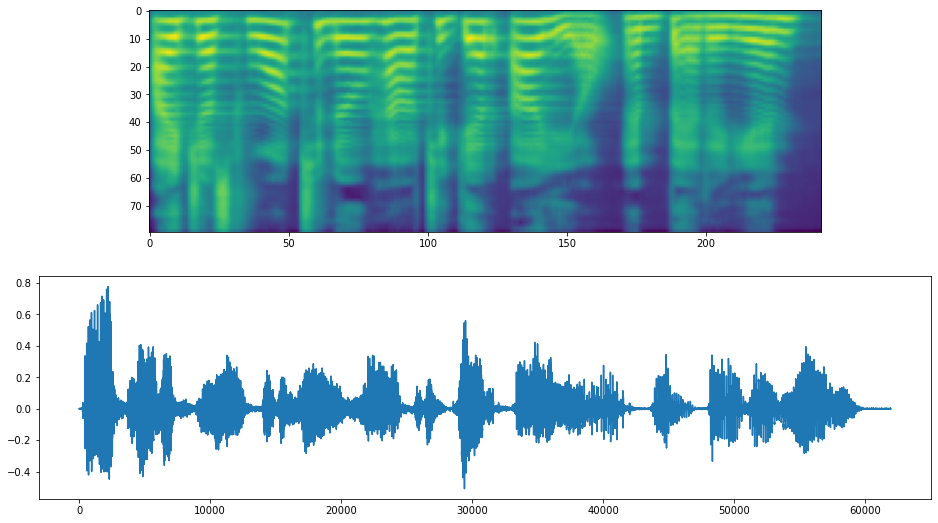

In [68]:
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9))
ax1.imshow(spec[0].cpu().detach())
ax2.plot(waveforms[0].cpu().detach())

In [69]:
torchaudio.save(os.path.join(data_root_path,'audio_waveflow.wav'),
                waveforms[0:1].cpu(),
                sample_rate=22050)
IPython.display.Audio(os.path.join(data_root_path,'audio_waveflow.wav'))